# Homework Session 2 - Regression

## Preparations

In [51]:
# dependencies
import pandas as pd
import numpy as np
import os
import seaborn as sns

In [2]:
# check working directory
os.getcwd()

'/Users/fakrueg/projects/ml-zoomcamp/homework'

In [3]:
# load data
df = pd.read_csv("../data/laptops.csv")

In [4]:
# clean and process the data

# change column names to lower case and replace space with underscore
df.columns = df.columns.str.lower().str.replace(" ", "_")

# select columns for further use
df = df[["ram", "storage", "screen", "final_price"]]

## Exploratory Data Analysis

<Axes: ylabel='Frequency'>

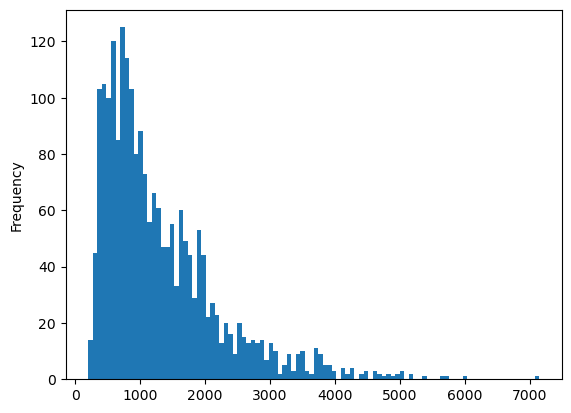

In [5]:
# plot the data to see if it has a long tail
df["final_price"].plot(kind="hist", bins=100)

Yes, it has a long tail.

## Question 1

In [6]:
# look for missing values in the data frame
df.isna().any()

ram            False
storage        False
screen          True
final_price    False
dtype: bool

The column containing missing values is `screen`,

## Questions 2

What is the 50th percentile or rather the median?

In [7]:
df["ram"].median()

np.float64(16.0)

Split the data set.

In [8]:
# prepare and split the dataset

# get sizes of different subsets
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

# shuffle data frame reproducibly to get more balanced sets
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

# get different split subsets
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# log transform label variable and store in its own object
y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

# remove label variable from feature data frames 
# now it's only left in its own previously made object y_...
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [9]:
df_train, y_train

(      ram  storage  screen
 0      32     1000    15.6
 1       4       64    14.1
 2      32     1000    14.0
 3      16      512    13.3
 4      32     1000    16.0
 ...   ...      ...     ...
 1291    8      256    14.0
 1292   32     1000    16.0
 1293   16      512    15.6
 1294   16      512    14.0
 1295   16      512    14.0
 
 [1296 rows x 3 columns],
 array([7.024907  , 5.30851519, 6.90649448, ..., 6.96602419, 7.42177579,
        6.96318999]))

## Question 3

### Missing Value Imputation

Impute missing values in the `screen` column.

In [10]:
# check which one of the data sets even contains any missing values that need to be imputed

# store the three data sets in a list
split_features = [df_train, df_val, df_test]

# interate through them and see which one has missing values.
for dataframe in split_features:
    print(dataframe.isna().any(), "\n")

ram        False
storage    False
screen      True
dtype: bool 

ram        False
storage    False
screen      True
dtype: bool 

ram        False
storage    False
screen     False
dtype: bool 



In [39]:
# define a function for imputing the data frames
# this function is very much tailored for this specific setup
# it won't be meaningful, for example, if order of data sets is changed
# but for this use case, it is sufficient :)

def impute_missing_values(datasets, fill_method):
    
    # iterate through all data passed frames
    for i in range(len(split_features)):
        
        # fill data with zeros if selected
        if fill_method == "zero":
            datasets[i] = datasets[i].fillna(0)
            
        # fill data with mean if selected
        if fill_method == "mean":
            
            # determine mean of train set to impute with -> always impute with this one
            # train is the first data set passed here
            mean_train = datasets[0]["screen"].mean()
            
            # use mean for imputation
            datasets[i] = datasets[i].fillna(mean_train)
    
    return datasets[0], datasets[1], datasets[2]


# call function and assign to new objects
# impute using zero
df_train_zero, df_val_zero, df_test_zero = impute_missing_values(datasets=split_features,
                                                                 fill_method="zero")

# impute using the mean
df_train_mean, df_val_mean, df_test_mean = impute_missing_values(datasets=split_features,
                                                                 fill_method="mean")

In [40]:
# test if imputation worked
# for imputation with zero
for dataframe in [df_train_zero, df_val_zero, df_test_zero]:
    print(dataframe.isna().any(), "\n")

ram        False
storage    False
screen     False
dtype: bool 

ram        False
storage    False
screen     False
dtype: bool 

ram        False
storage    False
screen     False
dtype: bool 



In [42]:
# test if imputation worked
# for imputation with zero
for dataframe in [df_train_mean, df_val_mean, df_test_mean]:
    print(dataframe.isna().any(), "\n")

ram        False
storage    False
screen     False
dtype: bool 

ram        False
storage    False
screen     False
dtype: bool 

ram        False
storage    False
screen     False
dtype: bool 



No more missing values left.

### Training the Model

In [44]:
# code from the lessons for training a linear regression model
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [46]:
# train the model using the data imputed with zeros
w0_zero, w_zero = train_linear_regression(
    X=df_train_zero,
    y=y_train
)

# train the model using the data imputed with mean
w0_mean, w_mean = train_linear_regression(
    X=df_train_mean,
    y=y_train
)

### Getting the Predictions

In [50]:
# get the predictions for model trained on data imputed with zeros
y_pred_zero = w0_zero + df_train_zero.dot(w_zero)

# get the predictions for model trained on data imputed with mean
y_pred_mean = w0_mean + df_train_mean.dot(w_mean)

<Axes: ylabel='Count'>

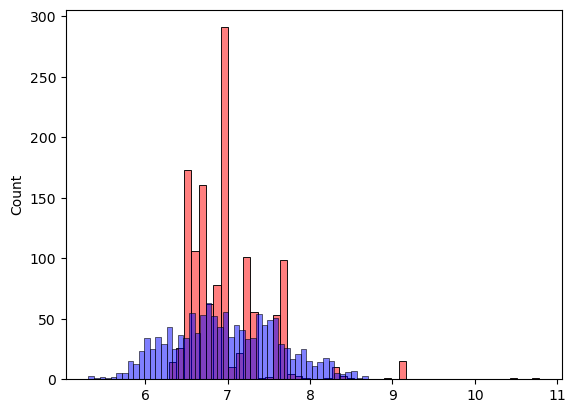

In [52]:
# compare predicted values to labels from training for zero imputed 
sns.histplot(y_pred_zero, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

<Axes: ylabel='Count'>

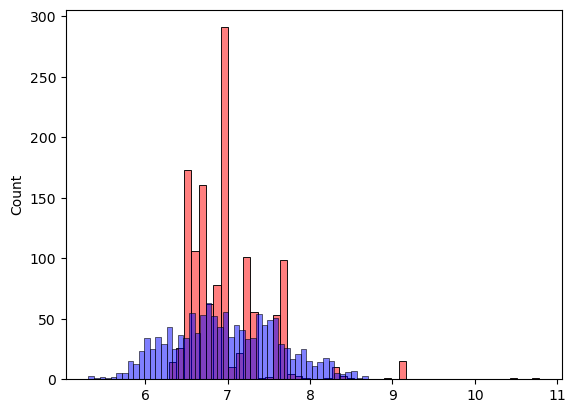

In [53]:
# compare predicted values to labels from training for mean imputed 
sns.histplot(y_pred_mean, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [58]:
# define function for RSME (taken from lesson's notebook)
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [62]:
# calculate RSME for predicted values from model trained on zero imputed
score = rmse(y_train, y_pred_zero)
round(score, 2)

np.float64(0.45)

In [63]:
# calculate RSME for predicted values from model trained on mean imputed
score = rmse(y_train, y_pred_mean)
round(score, 2)

np.float64(0.45)

## Question 4

In [68]:
# make list for regularization parameter r
reg_parameter = [0, 0.01, 0.1, 1, 5, 10, 100]

In [69]:
# define function for training a regularized linear regression model
# (code taken from lesson's notebook)
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [95]:
# make list for saving RMSE to
RMSE_list = []

# interate through all values for r and train and evaluate a regularized model each
for r in reg_parameter:
    # train regularized model
    w0, w = train_linear_regression_reg(X=df_train_zero,
                                        y=y_train,
                                        r=r)
    
    # get predictions using the weights
    y_pred = w0 + df_val_zero.dot(w)
    
    # calculate RMSE
    RMSE = round(rmse(y_val, y_pred), 2)
    
    # add RMSE to list
    RMSE_list.append(RMSE)

# have a look at RMSE
print(RMSE_list)

# find minimum RSME
print(min(RMSE_list))    

[np.float64(0.43), np.float64(0.43), np.float64(0.43), np.float64(0.43), np.float64(0.46), np.float64(0.51), np.float64(0.67)]
0.43


Four values for r have the same RMSE: 0.43

If multiple ones have the same value, we are supposed to pick the smallest r.

So, the answer to this question is `r = 0`

## Question 5

In [117]:
def full_pipeline_different_seeds(random_seed):
    
    # prepare and split the dataset
    # get sizes of different subsets
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    # shuffle data frame reproducibly to get more balanced sets
    idx = np.arange(n)
    np.random.seed(random_seed)
    np.random.shuffle(idx)

    # get different split subsets
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    # reset index
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # log transform label variable and store in its own object
    y_train = np.log1p(df_train.final_price.values)
    y_val = np.log1p(df_val.final_price.values)
    y_test = np.log1p(df_test.final_price.values)

    # remove label variable from feature data frames 
    # now it's only left in its own previously made object y_...
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    # call function and assign to new objects
    # impute using zero
    df_train_zero, df_val_zero, df_test_zero = impute_missing_values(datasets=split_features,
                                                                    fill_method="zero")

    # train the model using the data imputed with zeros
    w0_zero, w_zero = train_linear_regression(
        X=df_train_zero,
        y=y_train
    )

    # get the predictions for model trained on data imputed with zeros
    y_pred_zero = w0_zero + df_val_zero.dot(w_zero)
    
    # reverse log transformation of labels
    y_val_rev = np.expm1(y_val)
    y_pred_rev = np.expm1(y_pred_zero)

    # get RMSE
    RMSE_score = rmse(y_val_rev, y_pred_rev)
    
    return RMSE_score

In [118]:
# make list of seeds from exercise
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# make list to contain RMSE
RMSE_question5 = []

# call the function for the different seeds from the exercise
for seed in seeds:
    RMSE_question5.append(full_pipeline_different_seeds(random_seed=seed))
    
# have a look at the result
RMSE_question5

[np.float64(910.3274631696227),
 np.float64(950.0820283123493),
 np.float64(944.3781755681259),
 np.float64(928.8413609349392),
 np.float64(924.7954311238566),
 np.float64(868.2441459302062),
 np.float64(997.1147523105459),
 np.float64(924.1907246876143),
 np.float64(972.1813956792888),
 np.float64(967.3303370987575)]

In [119]:
# calculate standard deviation of RMSE values
round(np.std(RMSE_question5), 3)

np.float64(34.329)

## Question 6

In [130]:
def full_pipeline_regularized(random_seed=9):
    
    # prepare and split the dataset
    # get sizes of different subsets
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    # shuffle data frame reproducibly to get more balanced sets
    idx = np.arange(n)
    np.random.seed(random_seed)
    np.random.shuffle(idx)

    # get different split subsets
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    # reset index
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # combine train and val sets
    df_train_combined = pd.concat([df_train, df_val], axis=0)
    
    # get labels in a new object
    y_train_combined = df_train_combined.final_price.values
    y_test = df_test.final_price.values    
    
    # remove label variable from feature data frames 
    # now it's only left in its own previously made object y_...
    del df_train_combined['final_price']
    del df_test['final_price']

    # call function and assign to new objects
    # impute using zero
    df_train_combined, df_test, dummy = impute_missing_values(datasets=[df_train_combined, df_test, df_val],
                                                       fill_method="zero")

    # train the model using the data imputed with zeros
    w0_zero, w_zero = train_linear_regression_reg(
        X=df_train_combined,
        y=y_train_combined,
        r=0.001
    )

    # get the predictions for model trained on data imputed with zeros
    y_pred = w0_zero + df_test.dot(w_zero)
    
    # reverse log transformation of labels
    #y_val_rev = np.expm1(y_val)
    #y_pred_rev = np.expm1(y_pred_zero)

    # get RMSE
    RMSE_score = rmse(y_test, y_pred)
    
    return RMSE_score

# call function and round value
round(full_pipeline_regularized(), 2)

np.float64(608.61)